# Creating a Stress Detection Tool using Data From Subreddits: EDA

In this notebook I will be performing EDA on the dataset I created in the first notebook (data wrangling).  I will be breaking down things like which subreddits the comments are coming from, how long the average comment in the dataset is, and if there are any interesting and relevant ngrams within each category (stress, no stress) of the dataset.

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import re

import nltk
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

import pickle

#### Import dataframe from pickle

In [2]:
df = pd.read_pickle('df.pickle')

#### Review dataframe to make sure everything looks right
* .head and .tail
* .shape

In [3]:
df.head(5)

,subreddit,text,text_preproc,label,stress_label
0,happy,Welcome to /r/happy where we support people in...,welcome to rhappy where we support people in t...,0,no stress
1,happy,"You are good people, Mike.",you are good people mike,0,no stress
2,happy,"Wanna come to Knight Lake near Waupaca, Wiscon...",wanna come to knight lake near waupaca wiscons...,0,no stress
3,happy,"“But, I thought the old lady dropped it into t...",“but i thought the old lady dropped it into th...,0,no stress
4,happy,Yay! Thank you for being kind and returning it!,yay thank you for being kind and returning it,0,no stress


In [4]:
df.tail(5)

,subreddit,text,text_preproc,label,stress_label
5136,relationships,"* Her, a week ago: Precious, how are you? (I i...",her a week ago precious how are you i ignored...,0,no stress
5137,ptsd,I don't have the ability to cope with it anymo...,i dont have the ability to cope with it anymor...,1,stress
5138,anxiety,In case this is the first time you're reading ...,in case this is the first time youre reading t...,0,no stress
5139,almosthomeless,Do you find this normal? They have a good rela...,do you find this normal they have a good relat...,0,no stress
5140,ptsd,I was talking to my mom this morning and she s...,i was talking to my mom this morning and she s...,1,stress


In [5]:
df.shape

(5141, 5)

#### Count occurences of each subreddit

In [6]:
df['subreddit'].value_counts()

happy               1217
ptsd                 711
relationships        694
anxiety              650
domesticviolence     388
goodnews             371
assistance           355
survivorsofabuse     315
homeless             220
almosthomeless        99
stress                78
food_pantry           43
Name: subreddit, dtype: int64

#### Subreddits Pie Chart:
* Here we can see the breakdown of which subreddits the comments came from
* Although we called an equal number of 'top posts' from each of these subreddits, each subreddit may have had a different number of top posts and/or number of comments per top post, leading to the discrepencies

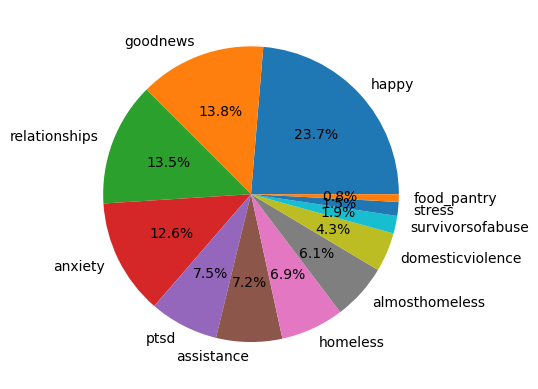

In [7]:
plt.pie(df['subreddit'].value_counts(), labels=df['subreddit'].unique().tolist(), autopct='%1.1f%%')
plt.show()

#### Look at average comment length
* Here we'll look at the min, max, and average length of comments
* Using a histogram we can see that very few comments go above 1000 characters

In [8]:
print('Min length: {}'.format(min(df['text_preproc'].str.len())))
print('Max length: {}'.format(max(df['text_preproc'].str.len())))
print('Average Length :  {}'.format(df['text_preproc'].str.len().mean()))

Min length: 1
Max length: 6262
Average Length :  349.50651624197627


<AxesSubplot: >

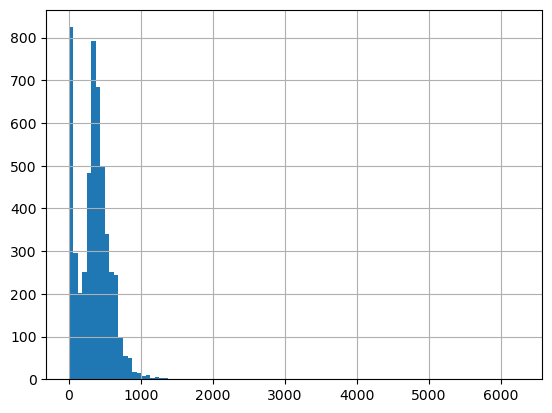

In [9]:
df['text_preproc'].str.len().hist(bins=100)

#### Finding most used words, bigrams, trigrams
* First I am splitting the datasets into 'stress' and 'no stress'
* I am then making a corpus by iterating through the preprocessed column of the dataframe

In [10]:
df_stress = df[df["stress_label"] == 'stress']
df_nostress = df[df["stress_label"] == 'no stress']

In [11]:
s_corpus = {}
s_corpus_string = ''
for t in df_stress:
    s_corpus[t]= ' '.join(df_stress['text_preproc'].tolist())
s_corpus = list(s_corpus.values())
for x in s_corpus:
    s_corpus_string += x
    
s_corpus_string = re.sub(r'[^\w\s]', '', s_corpus_string)

In [12]:
n_corpus = {}
n_corpus_string = ''
for t in df_nostress:
    n_corpus[t]= ' '.join(df_nostress['text_preproc'].tolist())
n_corpus = list(n_corpus.values())
for x in n_corpus:
    n_corpus_string += x
    
n_corpus_string = re.sub(r'[^\w\s]', '', n_corpus_string)

#### Removing stopwords
* First I am reviewing the default stopwords and then adding some more that are specific to my data

In [13]:
stopwords = stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
stop_list = ['moderator', 'bot', 'moderators', 'bots', 'contact', 'join', 'subreddit', 'discord', 'automatically', 'invite', 'link']
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(stop_list)

In [15]:
s_corpus_string = ' '.join([word for word in s_corpus_string.split() if word not in stpwrd])

In [16]:
n_corpus_string = ' '.join([word for word in n_corpus_string.split() if word not in stpwrd])

#### Computing frequency and sorting values
* Here I am creating two functions
* The first function will take the corpus and n value (2 for bigram, 3 for trigram, and so on if desired) and find the ngrams that exist and frequency of each
* The second function will order the dictionary that the first function returned and return the top 20 values in an easy to read format

In [17]:
def compute_freq(sentence, n_value):

    tokens = nltk.word_tokenize(sentence)
    ngrams = nltk.ngrams(tokens, n_value)
    ngram_fdist = nltk.FreqDist(ngrams)
    return ngram_fdist

In [18]:
def sort_freq(value):
    value = sorted(freq_dist.items(), key=lambda x:x[1], reverse=True)
    value = dict(value)
    freq_df = pd.DataFrame.from_dict(value, orient='index')
    freq_df = freq_df.reset_index()
    freq_df.columns = ['ngram', 'count']
    return freq_df.head(20)

#### Stress bigram:
* Some notable stress bigrams: 'can not,' 'dont want,' 'panic attack,' 'panic attacks'

In [19]:
freq_dist = compute_freq(s_corpus_string, 2)

sort_freq(freq_dist)

,ngram,count
0,"(feel, like)",1480
1,"(dont, know)",1260
2,"(dont, want)",500
3,"(like, im)",405
4,"(can, not)",310
5,"(im, going)",280
6,"(even, though)",265
7,"(im, scared)",265
8,"(panic, attacks)",255
9,"(anyone, else)",250


#### Stress trigrams:
* Many of the stress trigrams seem like an expansion of the bigrams
* Many of these trigrams include some form of the word 'feel,' 'dont,' 'know,' or some combination of those
* Other notable trigrams: 'mental health issues,' 'feel like shit'

In [20]:
freq_dist = compute_freq(s_corpus_string, 3)

sort_freq(freq_dist)

,ngram,count
0,"(feel, like, im)",275
1,"(dont, even, know)",140
2,"(dont, feel, like)",80
3,"(dont, know, feel)",75
4,"(dont, know, anymore)",75
5,"(dont, really, know)",70
6,"(long, story, short)",60
7,"(dont, know, im)",60
8,"(know, feel, like)",55
9,"(feel, like, cant)",50


#### No stress bigrams:
* Even though I filted out some additonal stopwords specific to reddit/subreddits, it is clear that not all of them can be filtered out
* For example, 'action performed' is obviously a bot comment, and based on frequency, we can assume 'performed please,' and  'questions concerns' are as well
* Ignoring ngrams such as these, some bigrams of not in the no stress category are: 'good things', and 'youre welcome'

In [21]:
freq_dist = compute_freq(n_corpus_string, 2)

sort_freq(freq_dist)

,ngram,count
0,"(action, performed)",990
1,"(performed, please)",990
2,"(questions, concerns)",990
3,"(dont, know)",810
4,"(youre, welcome)",560
5,"(dont, feel)",545
6,"(even, dont)",525
7,"(know, dont)",520
8,"(dont, give)",520
9,"(hang, around)",515


#### No stress trigrams:
* Same problem as with the no stress bigrams but worse
* The no stress trigrams really do not give any further useful information

In [22]:
freq_dist = compute_freq(n_corpus_string, 3)

sort_freq(freq_dist)

,ngram,count
0,"(action, performed, please)",990
1,"(thanks, contributing, rgoodnews)",500
2,"(contributing, rgoodnews, enjoy)",500
3,"(rgoodnews, enjoy, come)",500
4,"(enjoy, come, us)",500
5,"(come, us, rgoodnews)",500
6,"(us, rgoodnews, server)",500
7,"(rgoodnews, server, httpsdiscordggum5b3jm)",500
8,"(server, httpsdiscordggum5b3jm, action)",500
9,"(httpsdiscordggum5b3jm, action, performed)",500
